In [ ]:
!pip install tensorflow

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import shutil
import os
from sklearn.model_selection import train_test_split

In [2]:
# Parameter
IMG_SIZE = 224  # Ukuran gambar untuk MobileNetV2
BATCH_SIZE = 32
EPOCHS = 20

In [24]:
# Direktori dataset
dataset_dir = "dataset_batik"
train_dir = "train_batik"
test_dir = "test_batik"

# Membuat folder untuk train, test, dan val jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Daftar semua subfolder (kelas)
subfolders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

# Membagi data menjadi train, test, dan val
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_dir, subfolder)
    
    # Membuat folder untuk kelas di dalam folder train, test, dan val
    train_subfolder = os.path.join(train_dir, subfolder)
    test_subfolder = os.path.join(test_dir, subfolder)
    
    os.makedirs(train_subfolder, exist_ok=True)
    os.makedirs(test_subfolder, exist_ok=True)
    
    # Ambil semua gambar di dalam subfolder
    images = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
    
    # Bagi data menggunakan train_test_split dua tahap
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Pindahkan gambar ke folder train, val, dan test
    for image in train_images:
        old_image_path = os.path.join(subfolder_path, image)
        new_image_path = os.path.join(train_subfolder, image)
        shutil.copy(old_image_path, new_image_path)

    for image in test_images:
        old_image_path = os.path.join(subfolder_path, image)
        new_image_path = os.path.join(test_subfolder, image)
        shutil.copy(old_image_path, new_image_path)

print("Data telah dibagi menjadi folder train dan test dengan komposisi 80%, 20%.")


Data telah dibagi menjadi folder train dan test dengan komposisi 80%, 20%.


In [3]:
dataset_dir = "dataset_batik"
train_dir = "train_batik"
test_dir = "test_batik"

# Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Ubah ini menjadi tuple
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Ubah ini menjadi tuple
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Informasi jumlah kelas
num_classes = len(train_generator.class_indices)

Found 2402 images belonging to 15 classes.
Found 547 images belonging to 15 classes.


In [4]:
# Verifikasi jumlah gambar di train dan test
for subfolder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, subfolder)
    if os.path.isdir(subfolder_path):
        images = os.listdir(subfolder_path)
        print(f"Train class '{subfolder}' has {len(images)} images.")

for subfolder in os.listdir(test_dir):
    subfolder_path = os.path.join(test_dir, subfolder)
    if os.path.isdir(subfolder_path):
        images = os.listdir(subfolder_path)
        print(f"Test class '{subfolder}' has {len(images)} images.")


Train class 'batik_celup' has 162 images.
Train class 'batik_cendrawasih' has 160 images.
Train class 'batik_dayak' has 175 images.
Train class 'batik_geblek_renteng' has 183 images.
Train class 'batik_insang' has 173 images.
Train class 'batik_kawung' has 183 images.
Train class 'batik_lasem' has 167 images.
Train class 'batik_megamendung' has 189 images.
Train class 'batik_parang' has 184 images.
Train class 'batik_poleng' has 172 images.
Train class 'batik_pring' has 36 images.
Train class 'batik_sekar' has 133 images.
Train class 'batik_sidoluhur' has 140 images.
Train class 'batik_tambal' has 164 images.
Train class 'batik_truntum' has 181 images.
Test class 'batik_celup' has 37 images.
Test class 'batik_cendrawasih' has 36 images.
Test class 'batik_dayak' has 40 images.
Test class 'batik_geblek_renteng' has 42 images.
Test class 'batik_insang' has 39 images.
Test class 'batik_kawung' has 42 images.
Test class 'batik_lasem' has 38 images.
Test class 'batik_megamendung' has 43 imag

In [5]:
# Load base model tanpa top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom layers on top of base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Misal, 10 kelas untuk klasifikasi
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# # Model Transfer Learning
# base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False  # Bekukan layer pada model dasar untuk transfer learning

# # Tambahkan lapisan khusus
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)  # Dropout untuk mencegah overfitting
# x = Dense(256, activation="relu")(x)
# predictions = Dense(num_classes, activation="softmax")(x)

# # Buat model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Kompilasi model untuk transfer learning
# model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])

# Callback


In [6]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[reduce_lr]
)

Epoch 1/20


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.5212 - loss: 1.6367 - val_accuracy: 0.8190 - val_loss: 0.6094 - learning_rate: 0.0010
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8208 - loss: 0.5464 - val_accuracy: 0.8848 - val_loss: 0.4071 - learning_rate: 0.0010
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8715 - loss: 0.3877 - val_accuracy: 0.8921 - val_loss: 0.3740 - learning_rate: 0.0010
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8956 - loss: 0.3087 - val_accuracy: 0.8976 - val_loss: 0.3412 - learning_rate: 0.0010
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9159 - loss: 0.2630 - val_accuracy: 0.8940 - val_loss: 0.3997 - learning_rate: 0.0010
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9130 - loss: 0.2869 - val_accuracy: 0.9013 - val_loss: 0.3620 - learning_rate: 0.0010
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9378 - loss: 0.1837 - val_accuracy: 0.85

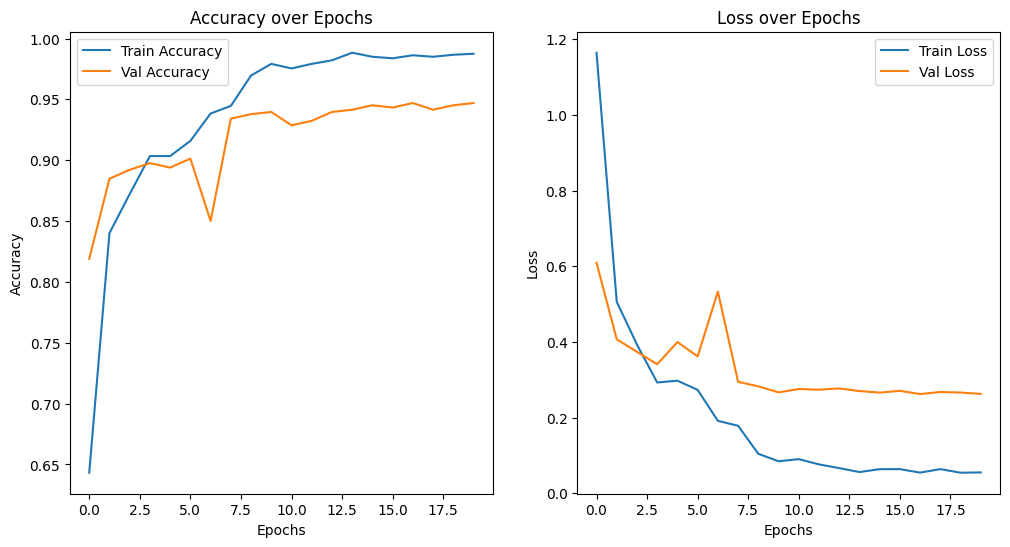

In [8]:
import matplotlib.pyplot as plt

# Plotting loss and accuracy
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [14]:
model.save("model_98_94_acc.h5")

In [13]:
# Evaluasi model menggunakan data testing
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8576 - loss: 0.4691
Test Loss: 0.4494
Test Accuracy: 0.8672


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


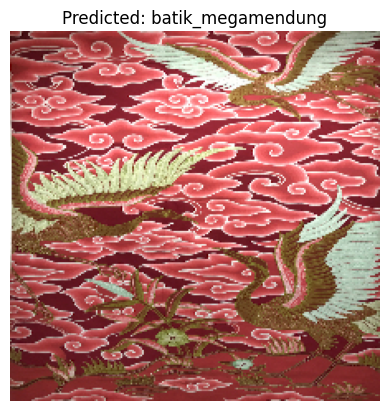

Predicted Label: batik_megamendung
Prediction Probabilities: [3.2434800e-06 2.5165357e-02 1.4943026e-06 9.1264343e-07 2.5689977e-07
 1.0104314e-06 1.6633398e-03 9.1552645e-01 5.5691611e-02 3.2919337e-07
 3.9408245e-04 6.9302652e-05 3.3668064e-07 1.4683057e-03 1.3987716e-05]


In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Fungsi untuk mengklasifikasikan gambar tunggal
def classify_single_image(image_path, model, test_generator, img_size=(224, 224)):
    # Memuat gambar
    img = image.load_img(image_path, target_size=img_size)
    
    # Mengubah gambar menjadi array numpy
    img_array = image.img_to_array(img)
    
    # Normalisasi gambar (menggunakan rescaling seperti di preprocessing data)
    img_array = img_array / 255.0
    
    # Menambahkan dimensi batch (karena model mengharapkan input berupa batch)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Prediksi kelas gambar
    predictions = model.predict(img_array)
    
    # Mendapatkan kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(predictions, axis=1)
    
    # Mengambil label kelas dari test_generator
    class_labels = list(test_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class[0]]
    
    # Menampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label, predictions[0]


# Uji dengan gambar tunggal
image_path = "test_batik/batik_megamendung/36.jpg"  # Ganti dengan path gambar yang ingin Anda klasifikasikan
predicted_label, prediction_probs = classify_single_image(image_path, model, test_generator)

print(f"Predicted Label: {predicted_label}")
print(f"Prediction Probabilities: {prediction_probs}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step


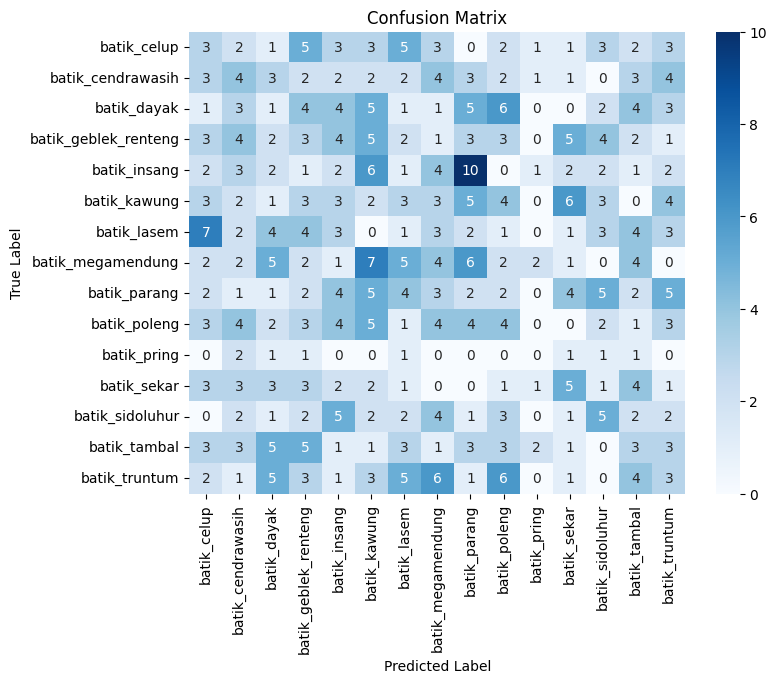

In [18]:
y_pred = model.predict(test_generator)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys() , yticklabels=test_generator.class_indices.keys() )
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
